In [23]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from typing import *
from numpy._typing import * 


In [24]:
def split_image_into_blocks(image: ArrayLike, block_size: Any) -> ArrayLike:
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    height, width = image.shape[:2]
    
    n_blocks_height = height // block_height
    n_blocks_width = width // block_width
    blocks = np.zeros((n_blocks_height, n_blocks_width, block_height, block_width), dtype=image.dtype)
    for i in range(n_blocks_height):
        for j in range(n_blocks_width):
            block = image[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            blocks[i, j] = block
    return blocks


In [25]:
def get_block_center(i :int, j: int, block_size: Any):
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    
    return (round(block_height*(i+0.5) - 0.5),
            round(block_width*(j+0.5) - 0.5))

In [26]:
def Calculate_SAD(block1: np.ndarray, block2: np.ndarray):
    
    return np.sum(np.abs(block1 - block2))

In [27]:
def pad_zeros_around_image(image: np.ndarray, pad_size: int or Tuple[int, int]) -> ArrayLike:
    
    if isinstance(pad_size,int):
        pad_size_height =  pad_size_width = pad_size
    else : 
        assert len(pad_size) == 2 
        pad_size_height, pad_size_width = pad_size
    
    new_image = np.zeros((image.shape[0] + 2*pad_size_height, image.shape[1] + 2*pad_size_width))
    
    new_image[pad_size_height : new_image.shape[0] - pad_size_height, pad_size_width : new_image.shape[1] - pad_size_width] = image
    
    return new_image.astype(np.uint8)

In [40]:
def calculate_sad_with_surrounding_blocks(frame: np.ndarray, block: np.ndarray, start: Tuple[int, int], end = None, stride = 1) -> ArrayLike:
    assert len(start) == 2 
    block_height, block_width = block.shape
    start_height, start_width = start
    if end is None:
        end_height, end_width = start_height + block_height, start_width + block_width
    else: 
        assert len(end) == 2  
        end_height, end_width = end
    sad = []
    
    pad_size_height, pad_size_width = pad_size = block_height//2, block_width//2
    
    padded_img = pad_zeros_around_image(frame, pad_size)
    
    for i in range(start_height + pad_size_height, end_height + pad_size_width, stride):
        for j in range(start_width + pad_size_width, end_width + pad_size_width, stride):
            sad.append(
                Calculate_SAD(
                    padded_img[i - block_height//2 : i + block_height//2 , j - block_width//2 : j + block_width//2],
                    block
                )
            )
    
    sad = np.array(sad).reshape(block.shape)
    min_sad = np.min(sad)
    idx_sad = np.where(
        min_sad == sad
    )
    
    center_block_in_next_frame = start_height + block_height//2, start_width + block_width//2
    center_prev_block_in_current_frame = start_height + idx_sad[0][0], start_width + idx_sad[1][0]
    return center_prev_block_in_current_frame, center_block_in_next_frame

In [41]:
def sliding_window_blocks(frame: np.ndarray, blocks: np.ndarray) -> ArrayLike:
    n_blocks_height, n_blocks_width, block_height, block_width = blocks.shape
    
    motion_vectors = []
    
    for i in range(n_blocks_height):
        for j in range(n_blocks_width):
            center_prev_block_in_current_frame, center_block_in_next_frame = calculate_sad_with_surrounding_blocks(
                frame, blocks[i,j], start = (i * block_height ,j * block_width)
            )

            vector = {
                # 'coordinates_block': (i,j),
                'start_point': center_prev_block_in_current_frame,
                'end_point': center_block_in_next_frame
            }
            
            motion_vectors.append(vector)

    return motion_vectors

In [47]:
def visualize_motion_vectors(frame: np.ndarray, motion_vectors: ArrayLike) -> ArrayLike:
    vectors_map = np.zeros_like(frame)
    
    for vector in motion_vectors:
        start_point = vector['start_point']
        end_point = vector['end_point']
        cv.line(vectors_map, start_point, end_point, color = (255,255,255), thickness = 1)
    return vectors_map
        

TypeError: typing.Union[numpy._typing._array_like._SupportsArray[numpy.dtype], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[typing.Union[bool, int, float, complex, str, bytes]]] is not a generic class

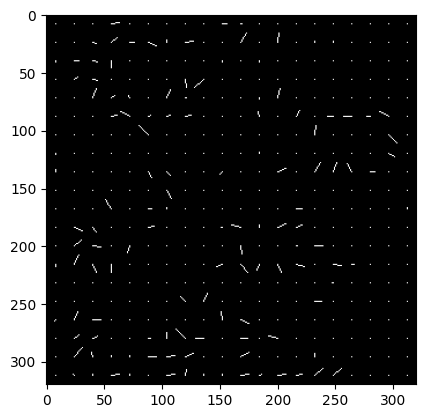

In [46]:
block_size = 16
img_size = (320,320)
frame1 = cv.imread('frame1.jpg', 0)
frame2 = cv.imread('frame2.jpg', 0)

frame1 = cv.resize(frame1, img_size)
frame2 = cv.resize(frame2, img_size)


blocks = split_image_into_blocks(frame2, block_size)
vector = sliding_window_blocks(frame1, blocks)
map = visualize_motion_vectors(frame1, vector)
plt.imshow(map, 'gray')

In [34]:
block = split_image_into_blocks(b, 8)
vector = sliding_window_blocks(a, block)